# Classes and functions from FairSMOTE

In [139]:
from __future__ import print_function, division
import pdb
import unittest
import random
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors as NN

class smote(object):
  def __init__(self, pd_data, neighbor=5,r=2 ,up_to_num=[],auto=True):
    """
    :param pd_data: panda.DataFrame, the last column must be class label
    :param neighbor: num of nearst neighbors to select
    :param up_to_num: size of minorities to over-sampling
    :param up_to_max: if up_to_num is not supplied, all minority classes will
                      be over-sampled as much as majority class
    :return panda.DataFrame smoted data
    """
    self.set_data(pd_data)
    self.auto = auto
    self.neighbor = neighbor
    self.up_to_max = False
    self.up_to_num = up_to_num
    self.r = r
    self.label_num = len(set(pd_data[pd_data.columns[-1]].values))
    #if up_to_num:
    #  label_num = len(set(pd_data[pd_data.columns[-1]].values))
    #  if label_num - 1 != len(up_to_num):
    #    raise ValueError(
    #      "should set smoted size for " + str(label_num - 1) + " minorities")
    #  self.up_to_num = up_to_num
    #else:
    #  self.up_to_max = True

  def set_data(self, pd_data):
    if not pd_data.empty:# and isinstance(
        #pd_data.ix[:, pd_data.columns[-1]].values[0], str):
      self.data = pd_data
    else:
      raise ValueError(
        "The last column of pd_data should be string as class label")

  def get_majority_num(self):
    total_data = self.data.values.tolist()
    labelCont = Counter(self.data[self.data.columns[-1]].values)
    majority_num = max(labelCont.values())
    return majority_num

  def run(self):
    """
    run smote
    """

    def get_ngbr(data_no_label, knn):
      rand_sample_idx = random.randint(0, len(data_no_label) - 1)
      rand_sample = data_no_label[rand_sample_idx]
      distance, ngbr = knn.kneighbors(rand_sample.reshape(1, -1))
      # while True:
      rand_ngbr_idx = random.randint(0, len(ngbr))
      #   if distance[rand_ngbr_idx] == 0:
      #     continue  # avoid the sample itself, where distance ==0
      #   else:
      return data_no_label[rand_ngbr_idx], rand_sample

    total_data = self.data.values.tolist()
    labelCont = Counter(self.data[self.data.columns[-1]].values)
    majority_num = max(labelCont.values())
    for label, num in labelCont.items():
      if num < majority_num:
        to_add = majority_num - num
        last_column = self.data[self.data.columns[-1]]
        data_w_label = self.data.loc[last_column == label]
        data_no_label = data_w_label[self.data.columns[:-1]].values
        if len(data_no_label) < self.neighbor:
          num_neigh = len(data_no_label) # void # of neighbors >= sample size
        else:
          num_neigh = self.neighbor
        knn = NN(n_neighbors=num_neigh,p=self.r,algorithm='ball_tree').fit(data_no_label)
        if self.auto:
          to_add = to_add
        else:
          to_add = self.up_to_num
        for _ in range(to_add):
          rand_ngbr, sample = get_ngbr(data_no_label, knn)
          new_row = []
          for i, one in enumerate(rand_ngbr):
            gap = random.random()
            new_row.append(max(0, sample[i] + (
            sample[i] - one) * gap))  # here, feature vlaue should >=0
          new_row.append(label)
          total_data.append(new_row)
    return pd.DataFrame(total_data)

In [140]:
from __future__ import print_function, division
import pdb
import unittest
import random
from collections import Counter
import pandas as pd
import numpy as np
from scipy.spatial import distance as dist
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors as NN

def get_ngbr(df, knn):
            rand_sample_idx = random.randint(0, df.shape[0] - 1)
            parent_candidate = df.iloc[rand_sample_idx]
            ngbr = knn.kneighbors(parent_candidate.values.reshape(1,-1),3,return_distance=False)
            candidate_1 = df.iloc[ngbr[0][0]]
            candidate_2 = df.iloc[ngbr[0][1]]
            candidate_3 = df.iloc[ngbr[0][2]]
            return parent_candidate,candidate_2,candidate_3

def generate_samples(no_of_samples,df,df_name):

    total_data = df.values.tolist()
    knn = NN(n_neighbors=5,algorithm='auto').fit(df)

    for _ in range(no_of_samples):
        cr = 0.8
        f = 0.8
        parent_candidate, child_candidate_1, child_candidate_2 = get_ngbr(df, knn)
        new_candidate = []
        for key,value in parent_candidate.items():
            if isinstance(parent_candidate[key], bool):
                new_candidate.append(parent_candidate[key] if cr < random.random() else not parent_candidate[key])
            elif isinstance(parent_candidate[key], str):
                new_candidate.append(random.choice([parent_candidate[key],child_candidate_1[key],child_candidate_2[key]]))
            elif isinstance(parent_candidate[key], list):
                temp_lst = []
                for i, each in enumerate(parent_candidate[key]):
                    temp_lst.append(parent_candidate[key][i] if cr < random.random() else
                                    int(parent_candidate[key][i] +
                                        f * (child_candidate_1[key][i] - child_candidate_2[key][i])))
                new_candidate.append(temp_lst)
            else:
                new_candidate.append(abs(parent_candidate[key] + f * (child_candidate_1[key] - child_candidate_2[key])))
        total_data.append(new_candidate)

    final_df = pd.DataFrame(total_data)
    if df_name == 'Adult':
        final_df = final_df.rename(columns={0:"age",1:"education.num",2:"race",3:"sex",4:"capital.gain",5:"capital.loss",6:"hours.per.week",7:"income"}, errors="raise")
    if df_name == 'Compas':
        final_df = final_df.rename(columns={0:"sex",1:"age_cat",2:"race",3:"priors_count",4:"c_charge_degree",5:"Probability"}, errors="raise")
    if df_name == 'Default':
    	final_df = final_df.rename(columns={0:"ID",1:"LIMIT_BAL",2:"sex",3:"EDUCATION",4:"MARRIAGE",5:"AGE",6:"PAY_0",7:"PAY_2",8:"PAY_3",9:"PAY_4",10:"PAY_5",11:"PAY_6",12:"BILL_AMT1",13:"BILL_AMT2",14:"BILL_AMT3",15:"BILL_AMT4",16:"BILL_AMT5",17:"BILL_AMT6",18:"PAY_AMT1",19:"PAY_AMT2",20:"PAY_AMT3",21:"PAY_AMT4",22:"PAY_AMT5",23:"PAY_AMT6",24:"Probability"}, errors="raise")

    if df_name == 'German':
    	final_df = final_df.rename(columns={0:"Age",1:"Sex",2:"Job",3:"Credit_amount",4:"Duration",5:"young",6:"Housing_free",7:"Housing_own",8:"Housing_rent",9:"Saving_accounts_little",10:"Saving_accounts_moderate",11:"Saving_accounts_rich",12:"Checking_account_little",13:"Checking_account_moderate",14:"Checking_account_rich",15:"Risk"}, errors="raise")
                          #  feature_columns = ['Age', 'Sex', 'Job', 'Credit_amount', 'Duration', 'young','Housing_free', 'Housing_own', 'Housing_rent', 'Saving_accounts_little', 'Saving_accounts_moderate','Saving_accounts_rich', 'Checking_account_little','Checking_account_moderate', 'Checking_account_rich']

    if df_name == 'Heart':
    	final_df = final_df.rename(columns={0:"age",1:"sex",2:"cp",3:"trestbps",4:"chol",5:"fbs",6:"restecg",7:"thalach",8:"exang",9:"oldpeak",10:"slope",11:"ca",12:"thal",13:"Probability"}, errors="raise")
    if df_name == 'Bank':
        final_df = final_df.rename(columns={0:"age",1:"default",2:"balance",3:"housing",4:"loan",5:"day",6:"duration",7:"campaign",8:"pdays",9:"previous",10:"Probability"}, errors="raise")
    if df_name == 'Titanic':
        final_df = final_df.rename(columns={0:"Pclass",1:"sex",2:"Age",3:"SibSp",4:"Parch",5:"Fare",6:"Probability"}, errors="raise")
    if df_name == 'Student':
        final_df = final_df.rename(columns={0:'sex', 1:'age', 2:'Medu', 3:'Fedu', 4:'traveltime', 5:'studytime', 6:'failures',
       7:'schoolsup', 8:'famsup', 9:'paid', 10:'activities', 11:'nursery', 12:'higher',
       13:'internet', 14:'romantic', 15:'famrel', 16:'freetime', 17:'goout', 18:'Dalc', 19:'Walc',
       20:'health', 21:'absences', 22:'G1', 23:'G2', 24:'Probability'}, errors="raise")

    if df_name == 'Nursery':
        final_df = final_df.rename(columns={0:"great_pret",1:"has_nurs_critical",2:"has_nurs_improper",3:"has_nurs_less_proper",4:"has_nurs_proper",5:"has_nurs_very_crit",
                                            6:'form_complete', 7:'form_completed', 8:'form_foster', 9:'form_incomplete', 10:'children_1', 11:'children_2', 12:'children_3',13:'children_more',
                                            14:'housing_convenient', 15:'housing_critical', 16:'housing_less_conv', 17:'finance_convenient', 18:'finance_inconv', 19:'social_nonprob', 20:'social_problematic',
                                            21:'social_slightly_prob', 22:'health_not_recom', 23:'health_priority', 24:'health_recommended', 25:'parents_great_pret',
                                            26:'parents_pretentious',27:'parents_usual',28:"class"}, errors="raise")
    if df_name == 'Recruitment':
        final_df = final_df.rename(columns={0:'gender', 1:'age', 2:'ind-university_grade', 3:'ind-languages', 4:'nationality_Belgian', 5:'nationality_Dutch', 6:'nationality_German',
       7:'sport_Chess', 8:'sport_Cricket', 9:'sport_Football', 10:'sport_Golf', 11:'sport_Rugby', 12:'sport_Running',
       13:'sport_Swimming', 14:'sport_Tennis', 15:'ind-debateclub_False', 16:'ind-debateclub_True', 17:'ind-programming_exp_False', 18:'ind-programming_exp_True', 19:'ind-international_exp_False',
       20:'ind-international_exp_True', 21:'ind-entrepeneur_exp_False', 22:'ind-entrepeneur_exp_True', 23:'ind-exact_study_False', 24:'ind-exact_study_True',28:'company_A',
                                            29:'company_B',30:'company_C',31:'company_D',32:'decision',}, errors="raise")


    if df_name == 'Default_Credit':
            final_df = final_df.rename(columns={0:'ID', 1:'LIMIT_BAL', 2:'SEX', 3:'EDUCATION', 4:'MARRIAGE', 5:'AGE', 6:'PAY_0',
          7:'PAY_2', 8:'PAY_3', 9:'PAY_4', 10:'PAY_5', 11:'PAY_6',
          12:'BILL_AMT1', 13:'BILL_AMT2', 14:'BILL_AMT3', 15:'BILL_AMT4', 16:'BILL_AMT5', 17:'BILL_AMT6', 18:'PAY_AMT1',
          19:'PAY_AMT2', 20:'PAY_AMT3', 21:'PAY_AMT4', 22:'PAY_AMT5', 23:'PAY_AMT6',24:'default payment next month'}, errors="raise")
    return final_df

In [141]:
import time
import pandas as pd
import random,time,csv
import numpy as np
import math,copy,os
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import sklearn.metrics as metrics


import sys
sys.path.append(os.path.abspath('..'))
from imblearn import under_sampling, over_sampling

# from SMOTE import smote
# from imblearn.over_sampling import SMOTE

# from Measure import measure_final_score,calculate_recall,calculate_far,calculate_precision,calculate_accuracy
# from Generate_Samples import generate_samples



!pip uninstall numpy
!pip install numpy
! pip install ctgan
! pip install --upgrade category_encoders


# ! pip install table_evaluator

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import category_encoders as ce
import math
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, confusion_matrix
import os
from statistics import mean
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from datetime import datetime
import pprint
import json



Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/lib/python3.10/dist-packages/numpy-1.26.4.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-0cf96a72.3.23.dev.so
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/numpy/*
Proceed (Y/n)? Y
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 

In [142]:
# Record the start time
start_time = time.time()

# Load Dataset

In [143]:
# ## Load dataset
# from sklearn import preprocessing
# dataset_orig = pd.read_csv('../data/adult.data.csv')

# ## Drop NULL values
# dataset_orig = dataset_orig.dropna()

# ## Drop categorical features
# dataset_orig = dataset_orig.drop(['workclass','fnlwgt','education','marital-status','occupation','relationship','native-country'],axis=1)

# ## Change symbolics to numerics
# dataset_orig['sex'] = np.where(dataset_orig['sex'] == ' Male', 1, 0)
# dataset_orig['race'] = np.where(dataset_orig['race'] != ' White', 0, 1)
# dataset_orig['Probability'] = np.where(dataset_orig['Probability'] == ' <=50K', 0, 1)


# ## Discretize age
# dataset_orig['age'] = np.where(dataset_orig['age'] >= 70, 70, dataset_orig['age'])
# dataset_orig['age'] = np.where((dataset_orig['age'] >= 60 ) & (dataset_orig['age'] < 70), 60, dataset_orig['age'])
# dataset_orig['age'] = np.where((dataset_orig['age'] >= 50 ) & (dataset_orig['age'] < 60), 50, dataset_orig['age'])
# dataset_orig['age'] = np.where((dataset_orig['age'] >= 40 ) & (dataset_orig['age'] < 50), 40, dataset_orig['age'])
# dataset_orig['age'] = np.where((dataset_orig['age'] >= 30 ) & (dataset_orig['age'] < 40), 30, dataset_orig['age'])
# dataset_orig['age'] = np.where((dataset_orig['age'] >= 20 ) & (dataset_orig['age'] < 30), 20, dataset_orig['age'])
# dataset_orig['age'] = np.where((dataset_orig['age'] >= 10 ) & (dataset_orig['age'] < 10), 10, dataset_orig['age'])
# dataset_orig['age'] = np.where(dataset_orig['age'] < 10, 0, dataset_orig['age'])

# protected_attribute = 'race'

# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# dataset_orig = pd.DataFrame(scaler.fit_transform(dataset_orig),columns = dataset_orig.columns)


# dataset_orig_train, dataset_orig_test = train_test_split(dataset_orig, test_size=0.2,shuffle = True)

# # dataset_orig

## Fairness metrics and functions


In [144]:
def print_metrics(y_gt, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_gt, y_pred).ravel()
    print('conf matrix:\n ', confusion_matrix(y_gt, y_pred) ,
          '\naccuracy: ', (tp+tn)/(tp+tn+fn+fp),
          'precision: ', tp/(tp+fp),
          'recall: ', tp/(tp+fn),
          'fpr: ', fp/(fp+tn),
          'tpr: ', tp /(tp + fn),
          'fn+fp', fn+fp)
    #returm fpr, tpr, accuracy
    return fp/(fp+tn), tp /(tp + fn), (tp+tn)/(tp+tn+fn+fp)

# bias metric - equal opportunity difference
def opportunity_diff_tpr(tpr1, tpr2):
    return abs(tpr1-tpr2)

# bias metric - equal opportunity difference
def opportunity_diff_fpr(fpr1, fpr2):
    return abs(fpr1-fpr2)

# bias metric - avarage absolute odds difference
def odds_diff(tpr1, tpr2, fpr1, fpr2):
    return 0.5*(abs(tpr2-tpr1) + abs(fpr2-fpr1))

# bias metric - statistical parity difference
def parity_diff(y_pred_0, y_pred_1):
    return abs(len(y_pred_0)/(len(y_pred_0)+len(y_pred_1)) - len(y_pred_1)/(len(y_pred_1)+len(y_pred_0)))


    # bias metric - Disparate impact
def disparate_impact(y_pred_0, y_pred_1):
    return min((len(y_pred_0)/len(y_pred_0+y_pred_1)) / (len(y_pred_1)/len(y_pred_1+len(y_pred_0)))
    ,(len(y_pred_1)/len(y_pred_0+y_pred_1)) / (len(y_pred_0)/len(y_pred_1+len(y_pred_0))))

In [145]:
# calculate the bias of divided dataset by the privileged feature
def calc_bias(data,y, priv_feature,y_pred, experiment_text):
    data_full =  pd.concat([data, y], axis=1)
    data_full['y_pred'] = y_pred

    label = TARGET_COL
    print('performance for whole ds:'+ experiment_text)
    fpr, tpr, acc = print_metrics(data_full[TARGET_COL], data_full['y_pred'] )

    feature_cat_list = list(data[priv_feature].unique())
    #print(feature_cat_list)
    valid_cat0 = data_full[data_full[priv_feature]==feature_cat_list[0]]
    valid_cat1 = data_full[data_full[priv_feature]==feature_cat_list[1]]
    print('performance for 0 sub-group:')
    fpr_0, tpr_0 , acc_0 = print_metrics(valid_cat0[TARGET_COL], valid_cat0['y_pred'])
    print('performance for 1 sub-group:')

    fpr_1, tpr_1, acc_1 = print_metrics(valid_cat1[TARGET_COL], valid_cat1['y_pred'])
    op_diff = opportunity_diff_tpr(tpr_0, tpr_1)
    op_diff_fpr = opportunity_diff_fpr(fpr_0, fpr_1)
    od_diff = odds_diff(tpr_0, tpr_1, fpr_0, fpr_1)
    par_diff = parity_diff(valid_cat0[valid_cat0['y_pred']==1], valid_cat1[valid_cat1['y_pred']==1])
    dis_impact = disparate_impact(valid_cat0[valid_cat0['y_pred']==1], valid_cat1[valid_cat1['y_pred']==1])
    print('bias metrics:')
    print('equal opportunity for tpr: (close to 0)', op_diff)
    print('equal opportunity for fpr: (close to 0)', op_diff_fpr)
    print('avarage absolute odds difference: (close to 0)',od_diff)
    print('statistical parity difference: (close to 0) ',par_diff)
    print('disparate_impact: (close to 1) ',dis_impact)

#     # Plot for orig_data_one_priv.shape[0] and orig_data_one_non_priv.shape[0]
#     fig, axs = plt.subplots(1, 2, figsize=(12, 6))

#     # Bar colors
#     colors = ['blue', 'orange']

#     # Plot 1 - orig_data_one_priv and orig_data_one_non_priv
#     axs[0].bar(['priv', 'non_priv'], [tpr_0, tpr_1], color=colors)
#     axs[0].set_xlabel('Data Type')
#     axs[0].set_ylabel('Count')
#     axs[0].set_title('TPR(maximize)')

#     # Plot 2 - orig_data_zero_priv and orig_data_zero_non_priv
#     axs[1].bar(['priv', 'non_priv'], [fpr_0, fpr_1], color=colors)
#     axs[1].set_xlabel('Data Type')
#     axs[1].set_ylabel('Count')
#     axs[1].set_title('FPR(minimize)')

#     # Adjust spacing between subplots
#     plt.subplots_adjust(wspace=0.4)

#     # Show the plots
#     plt.show()

    return (op_diff,op_diff_fpr, od_diff,par_diff ,dis_impact,acc)

In [146]:
def fairness_metrics_roc_auc(data , y):
    clf = RandomForestClassifier(n_estimators=10, max_depth=5,random_state=1234)

    cv = StratifiedKFold(n_splits=5, random_state=1234, shuffle=True)
    results = pd.DataFrame(columns=['training_score', 'test_score'])

    fprs, tprs, scores, op_list ,op_f_list, od_list ,par_dif_list,dis_impact_list, acc_list = [], [], [], [],[], [], [],[],[]

    start_time = datetime.now()
    for (train, test), i in zip(cv.split(data, y), range(5)):
        clf.fit(data.iloc[train], y.iloc[train])
        _, _, auc_score_train = compute_roc_auc(train,clf, data, y)
        fpr, tpr, auc_score = compute_roc_auc(test,clf, data, y)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)
        y_pred = clf.predict(data.iloc[test])
        o_p, o_p_fpr, o_d ,par_dif, dis_impact, acc_ = calc_bias(data.iloc[test],  y.iloc[test], PRIV_FEATURE,y_pred, 'subexperiment - baseline Ensemble'+' model:'+str(i))
        acc_list.append(acc_)
        op_list.append(o_p)
        op_f_list.append(o_p_fpr)
        od_list.append(o_d)
        par_dif_list.append(par_dif)
        dis_impact_list.append(dis_impact)

    std_op = np.std(op_list)
    op_str = f"{mean(op_list):.3f} ± {std_op:.3f}"

    std_op_f = np.std(op_f_list)
    op_f_str = f"{mean(op_f_list):.3f} ± {std_op_f:.3f}"

    std_od = np.std(od_list)
    od_str = f"{mean(od_list):.3f} ± {std_od:.3f}"

    std_par_dif = np.std(par_dif_list)
    par_dif_str = f"{mean(par_dif_list):.3f} ± {std_par_dif:.3f}"

    std_dis_impact = np.std(dis_impact_list)
    dis_imp_str = f"{mean(dis_impact_list):.3f} ± {std_dis_impact:.3f}"


    std_acc = np.std(acc_list)
    acc_str = f"{mean(acc_list):.3f} ± {std_acc:.3f}"
    time_elapsed_baseline = datetime.now() - start_time
    plot_roc_curve(fprs, tprs);
    pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])
    print('Accaracy list : ', acc_list)
    print('equal opportunity for tpr : ', op_list)
    print('equal opportunity for fpr : ',op_f_list)
    print('odds difference list : ' , od_list)
    print('The mean accuracy is ', acc_str)
    print('The mean equal opportunity for tpr: (close to 0)', op_str)
    print('The mean equal opportunity for fpr: (close to 0)', op_f_str)
    print('The mean odds difference: (close to 0)',od_str)
    print('The mean parity difference: (close to 0)', par_dif_str)
    print('The mean disperate impact: (close to 1)',dis_imp_str)

    return acc_list, op_list, op_f_list ,od_list,par_dif_list , dis_impact_list

In [147]:
def fairness_metrics_roc_auc_no_print(data , y):
    clf = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=365)

    cv = StratifiedKFold(n_splits=5, random_state=124, shuffle=True)
    results = pd.DataFrame(columns=['training_score', 'test_score'])

    fprs, tprs, scores, op_list ,op_f_list, od_list ,par_dif_list,dis_impact_list, acc_list = [], [], [], [],[], [], [],[],[]

    start_time = datetime.now()
    for (train, test), i in zip(cv.split(data, y), range(5)):
        clf.fit(data.iloc[train], y.iloc[train])
        _, _, auc_score_train = compute_roc_auc(train,clf, data, y)
        fpr, tpr, auc_score = compute_roc_auc(test,clf, data, y)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)
        y_pred = clf.predict(data.iloc[test])
        o_p, o_p_fpr, o_d ,par_dif, dis_impact, acc_ = calc_bias(data.iloc[test],  y.iloc[test], PRIV_FEATURE,y_pred, 'subexperiment - baseline Ensemble'+' model:'+str(i))
        acc_list.append(acc_)
        op_list.append(o_p)
        op_f_list.append(o_p_fpr)
        od_list.append(o_d)
        par_dif_list.append(par_dif)
        dis_impact_list.append(dis_impact)

    return acc_list, op_list, op_f_list ,od_list,par_dif_list , dis_impact_list

## Roc & AUC functions¶


In [148]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""

    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs, acc = [], []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))

    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index,clf ,data, y):
    y_predict = clf.predict_proba(data.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

## Datasets & Params¶


In [149]:
# choose dataset
#DATASET_NAME = 'ADULT_SEX'
#DATASET_NAME = 'ADULT_RACE'
#DATASET_NAME ='COMPAS_RACE_AM'
#DATASET_NAME = 'COMPAS_SEX'
#DATASET_NAME='CREDIT_SEX'
#DATASET_NAME = 'BANK_AGE'
# DATASET_NAME = 'RECRUIT_SEX'
# DATASET_NAME = 'NURSERY'
DATASET_NAME = 'DEFAULT_CREDIT'

In [150]:
# upload kaggle.json file using user prompt
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving default of credit card clients.csv to default of credit card clients (4).csv
User uploaded file "default of credit card clients (4).csv" with length 2897209 bytes


In [151]:
if DATASET_NAME == 'ADULT_SEX':
    TARGET_COL = 'income'
    PRIV_FEATURE = "sex"
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 1
    orig_data = pd.read_csv('/content/adult.csv')
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == '<=50K' else 1)
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1,0)
    orig_data['race'] = np.where(orig_data['race'] != 'White', 0, 1)
    orig_data.replace('?',np.nan,inplace = True)
    orig_data.dropna(how='any',inplace = True)
    orig_data.drop_duplicates()
    orig_data.reset_index(inplace=True, drop=True)

    privileged_groups = [{'sex': 1}] # Male
    unprivileged_groups = [{'sex': 0}] # Female

    feature_columns = ['age', 'education.num','race', 'sex', 'capital.gain','capital.loss', 'hours.per.week']

    CATEGORICAL = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'native.country']


elif DATASET_NAME == 'ADULT_RACE':
    TARGET_COL = 'income'
    PRIV_FEATURE = 'race'
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 1
    orig_data = pd.read_csv('/content/adult.csv')
    print(orig_data)
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == '<=50K' else 1)
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1,0)
    orig_data['race'] = np.where(orig_data['race'] != 'White', 0, 1)

    # orig_data['black'] = np.where(orig_data['race'] == 'Black', 0,1)
    orig_data.replace('?',np.nan,inplace = True)
    orig_data.dropna(how='any',inplace = True)
    orig_data.drop_duplicates()
    orig_data.reset_index(inplace=True, drop=True)

    # feature_columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num',
    #    'marital.status', 'occupation', 'relationship', 'race', 'sex',
    #    'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'black']
    feature_columns = ['age', 'education.num','race', 'sex', 'capital.gain','capital.loss', 'hours.per.week']

    CATEGORICAL = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'native.country']

elif DATASET_NAME =='COMPAS_RACE_AM':
    orig_data = pd.read_csv('/content/compas-scores-two-years_v1.csv')
    orig_data = orig_data[((orig_data['days_b_screening_arrest'] <=30) &
      (orig_data['days_b_screening_arrest'] >= -30) &
      (orig_data['is_recid'] != -1) &
      (orig_data['c_charge_degree'] != 'O') &
      (orig_data['score_text'] != 'N/A')
     )]
    TARGET_COL = 'two_year_recid'
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1, 0)
    orig_data['am'] = np.where(orig_data['race'] == 'African-American', 1,0)
    PRIV_FEATURE = 'am'
#     PRIV_FEATURE = 'sex'
    PRIV_CLASS = 0
    PRIV_VALUE_FEATURE = 0
    feature_columns = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
               'days_b_screening_arrest', 'decile_score','am']
    CATEGORICAL = [ 'age_cat', 'race', 'c_charge_degree', 'score_text']



elif DATASET_NAME =='COMPAS_SEX':
    orig_data = pd.read_csv('../input/compastwoyears/compas-scores-two-years_v1.csv')
    orig_data = orig_data[((orig_data['days_b_screening_arrest'] <=30) &
      (orig_data['days_b_screening_arrest'] >= -30) &
      (orig_data['is_recid'] != -1) &
      (orig_data['c_charge_degree'] != 'O') &
      (orig_data['score_text'] != 'N/A')
     )]
    TARGET_COL = 'two_year_recid'
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1, 0)
    orig_data['am'] = np.where(orig_data['race'] == 'African-American', 1,0)
    PRIV_FEATURE = 'sex'
    PRIV_CLASS = 0
    PRIV_VALUE_FEATURE = 0
    feature_columns = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
               'days_b_screening_arrest', 'decile_score','am']
    CATEGORICAL = [ 'age_cat', 'race', 'c_charge_degree', 'score_text']


elif DATASET_NAME == 'CREDIT_SEX':
    orig_data = pd.read_csv('/content/german_credit_data.csv')
    TARGET_COL = 'Risk'
    PRIV_FEATURE = 'Sex'
    PRIV_CLASS = 0
    PRIV_VALUE_FEATURE = 0
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == 'bad' else 1)
    orig_data['Sex'] = np.where(orig_data['Sex'] == 'male', 0,1)
    orig_data = orig_data.drop(["Unnamed: 0"],axis=1)
    orig_data['young'] = orig_data['Age'].apply(lambda x: 0 if x < 25 else 1)
    orig_data = orig_data.drop(columns=['Purpose'])
    orig_data = orig_data.rename(columns={"Saving accounts": "Saving_accounts", "Checking account": "Checking_account","Credit amount":"Credit_amount"})
    CATEGORICAL = ['Housing', 'Saving_accounts' , 'Checking_account']
    feature_columns = ['Age', 'Sex', 'Job', 'Credit_amount', 'Duration', 'young','Housing_free', 'Housing_own', 'Housing_rent', 'Saving_accounts_little', 'Saving_accounts_moderate','Saving_accounts_rich', 'Checking_account_little','Checking_account_moderate', 'Checking_account_rich']

    orig_data = pd.get_dummies(orig_data, columns=CATEGORICAL)
    print(orig_data.columns)



elif DATASET_NAME =='BANK_AGE':
    orig_data = pd.read_csv('/kaggle/input/bank-marketing-dataset/bank.csv')
    TARGET_COL = 'deposit'
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == 'no' else 1)

    orig_data['age_cat'] = np.where(((pd.to_numeric(orig_data['age']) > 65) |  (pd.to_numeric(orig_data['age']) < 25)), 0,1)
    PRIV_FEATURE = 'age_cat'
    PRIV_VALUE_FEATURE = 0
    PRIV_CLASS = 1
    feature_columns = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'age_cat',
       'previous', 'poutcome']
    CATEGORICAL = [ 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']



elif DATASET_NAME == 'RECRUIT_SEX':
    orig_data = pd.read_csv('/content/recruitmentdataset-2022-1.3.csv')
    TARGET_COL = 'decision'
    PRIV_FEATURE = 'age'
    PRIV_VALUE_FEATURE = 1
    orig_data = orig_data.drop(['Id'],axis=1)
    orig_data['age'] = np.where(((pd.to_numeric(orig_data['age']) > 32) |  (pd.to_numeric(orig_data['age']) < 25)), 0,1)


    PRIV_CLASS = 1
    orig_data['gender'] = np.where(orig_data['gender'] == 'male', 0,1)
    orig_data['decision'] = np.where(orig_data['decision'] == False, 0,1)
    CATEGORICAL = [ 'nationality', 'sport',
       'ind-debateclub', 'ind-programming_exp', 'ind-international_exp',
       'ind-entrepeneur_exp', 'ind-exact_study', 'ind-degree',
       'company']

    # feature_columns = ['gender', 'age', 'nationality', 'sport', 'ind-university_grade',
    #    'ind-debateclub', 'ind-programming_exp', 'ind-international_exp',
    #    'ind-entrepeneur_exp', 'ind-languages', 'ind-exact_study', 'ind-degree',
    #    'company']
    feature_columns = ['gender', 'age', 'ind-university_grade', 'ind-languages',
       'nationality_Belgian', 'nationality_Dutch', 'nationality_German',
       'sport_Chess', 'sport_Cricket', 'sport_Football', 'sport_Golf',
       'sport_Rugby', 'sport_Running', 'sport_Swimming', 'sport_Tennis',
       'ind-debateclub_False', 'ind-debateclub_True',
       'ind-programming_exp_False', 'ind-programming_exp_True',
       'ind-international_exp_False', 'ind-international_exp_True',
       'ind-entrepeneur_exp_False', 'ind-entrepeneur_exp_True',
       'ind-exact_study_False', 'ind-exact_study_True', 'ind-degree_bachelor',
       'ind-degree_master', 'ind-degree_phd', 'company_A', 'company_B',
       'company_C', 'company_D']

    orig_data = pd.get_dummies(orig_data, columns=CATEGORICAL)
    print(orig_data.columns)

elif DATASET_NAME == 'NURSERY':

    orig_data = pd.read_csv('/content/nursery.csv')
    TARGET_COL = 'class'
    PRIV_FEATURE = 'great_pret'
    PRIV_VALUE_FEATURE = 1
    PRIV_CLASS = 0
    orig_data['class'] = np.where(orig_data['class'] == 'spec_prior', 1,0)
    orig_data['great_pret'] = np.where(orig_data['parents'] == 'great_pret', 1,0)

    feature_columns = list(orig_data.columns)
    feature_columns.remove(TARGET_COL)
    CATEGORICAL = ['has_nurs','form','children','housing','finance','social','health','parents']

    # feature_columns = ['gender', 'age', 'nationality', 'sport', 'ind-university_grade',
    #    'ind-debateclub', 'ind-programming_exp', 'ind-international_exp',
    #    'ind-entrepeneur_exp', 'ind-languages', 'ind-exact_study', 'ind-degree',
    #    'company']
    feature_columns = [ 'great_pret', 'has_nurs_critical', 'has_nurs_improper',
       'has_nurs_less_proper', 'has_nurs_proper', 'has_nurs_very_crit',
       'form_complete', 'form_completed', 'form_foster', 'form_incomplete',
       'children_1', 'children_2', 'children_3', 'children_more',
       'housing_convenient', 'housing_critical', 'housing_less_conv',
       'finance_convenient', 'finance_inconv', 'social_nonprob',
       'social_problematic', 'social_slightly_prob', 'health_not_recom',
       'health_priority', 'health_recommended', 'parents_great_pret',
       'parents_pretentious', 'parents_usual']

    orig_data = pd.get_dummies(orig_data, columns=CATEGORICAL)
    print(orig_data.columns)


elif DATASET_NAME == "DEFAULT_CREDIT":
    orig_data = pd.read_csv('/content/default of credit card clients.csv')
    TARGET_COL = 'default payment next month'
    PRIV_FEATURE = 'SEX'
    PRIV_VALUE_FEATURE = 1
    PRIV_CLASS = 0

    feature_columns = list(orig_data.columns)
    feature_columns.remove(TARGET_COL)
    CATEGORICAL = []


In [152]:
orig_data

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [153]:
from sklearn.preprocessing import MinMaxScaler



# dataset for training
orig_data.dropna(thresh=len(feature_columns)/2, inplace=True)
orig_data.reset_index(drop=True, inplace=True)

y_orig = orig_data[TARGET_COL]
# y_orig = orig_data[TARGET_COL].to_frame()

y_orig.dropna(inplace=True)

orig_data = orig_data.loc[:, feature_columns]

scaler = MinMaxScaler()
orig_data = pd.DataFrame(scaler.fit_transform(orig_data),columns = orig_data.columns)
# # data = data[feature_columns]
# encoder = ce.TargetEncoder(cols=CATEGORICAL)

# encoder.fit(orig_data, y_orig)
# orig_data_encoded = encoder.transform(orig_data)

In [154]:
orig_dataset = pd.concat([orig_data, y_orig], axis=1)

In [155]:
orig_dataset

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,0.000000,0.010101,1.0,0.333333,0.333333,0.051724,0.4,0.4,0.1,0.1,...,0.160138,0.080648,0.260979,0.000000,0.000409,0.000000,0.000000,0.000000,0.000000,1
1,0.000033,0.111111,1.0,0.333333,0.666667,0.086207,0.1,0.4,0.2,0.2,...,0.163220,0.084074,0.263485,0.000000,0.000594,0.001116,0.001610,0.000000,0.003783,1
2,0.000067,0.080808,1.0,0.333333,0.666667,0.224138,0.2,0.2,0.2,0.2,...,0.173637,0.095470,0.272928,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458,0
3,0.000100,0.040404,1.0,0.333333,0.333333,0.275862,0.2,0.2,0.2,0.2,...,0.186809,0.109363,0.283685,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892,0
4,0.000133,0.040404,0.0,0.333333,0.333333,0.620690,0.1,0.2,0.1,0.2,...,0.179863,0.099633,0.275681,0.002290,0.021779,0.011160,0.014493,0.001615,0.001284,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.999867,0.212121,0.0,0.500000,0.333333,0.310345,0.2,0.2,0.2,0.2,...,0.243036,0.111622,0.273259,0.009730,0.011875,0.005583,0.004907,0.011723,0.001892,0
29996,0.999900,0.141414,0.0,0.500000,0.666667,0.379310,0.1,0.1,0.1,0.1,...,0.168596,0.085794,0.260979,0.002103,0.002094,0.010042,0.000208,0.000000,0.000000,0
29997,0.999933,0.020202,0.0,0.333333,0.666667,0.275862,0.6,0.5,0.4,0.1,...,0.179805,0.101057,0.275854,0.000000,0.000000,0.024552,0.006763,0.004689,0.005864,1
29998,0.999967,0.070707,0.0,0.500000,0.333333,0.344828,0.3,0.1,0.2,0.2,...,0.209850,0.092403,0.298591,0.098334,0.002024,0.001315,0.003101,0.124174,0.003412,1


# Check original scores

performance for whole ds:subexperiment - baseline Ensemble model:0
conf matrix:
  [[4508  164]
 [ 918  410]] 
accuracy:  0.8196666666666667 precision:  0.7142857142857143 recall:  0.30873493975903615 fpr:  0.0351027397260274 tpr:  0.30873493975903615 fn+fp 1082
performance for 0 sub-group:
conf matrix:
  [[2791   98]
 [ 510  241]] 
accuracy:  0.832967032967033 precision:  0.7109144542772862 recall:  0.3209054593874834 fpr:  0.033921772239529246 tpr:  0.3209054593874834 fn+fp 608
performance for 1 sub-group:
conf matrix:
  [[1717   66]
 [ 408  169]] 
accuracy:  0.7991525423728814 precision:  0.7191489361702128 recall:  0.292894280762565 fpr:  0.03701626472237801 tpr:  0.292894280762565 fn+fp 474
bias metrics:
equal opportunity for tpr: (close to 0) 0.028011178624918365
equal opportunity for fpr: (close to 0) 0.003094492482848765
avarage absolute odds difference: (close to 0) 0.015552835553883565
statistical parity difference: (close to 0)  0.18118466898954705
disparate_impact: (close to

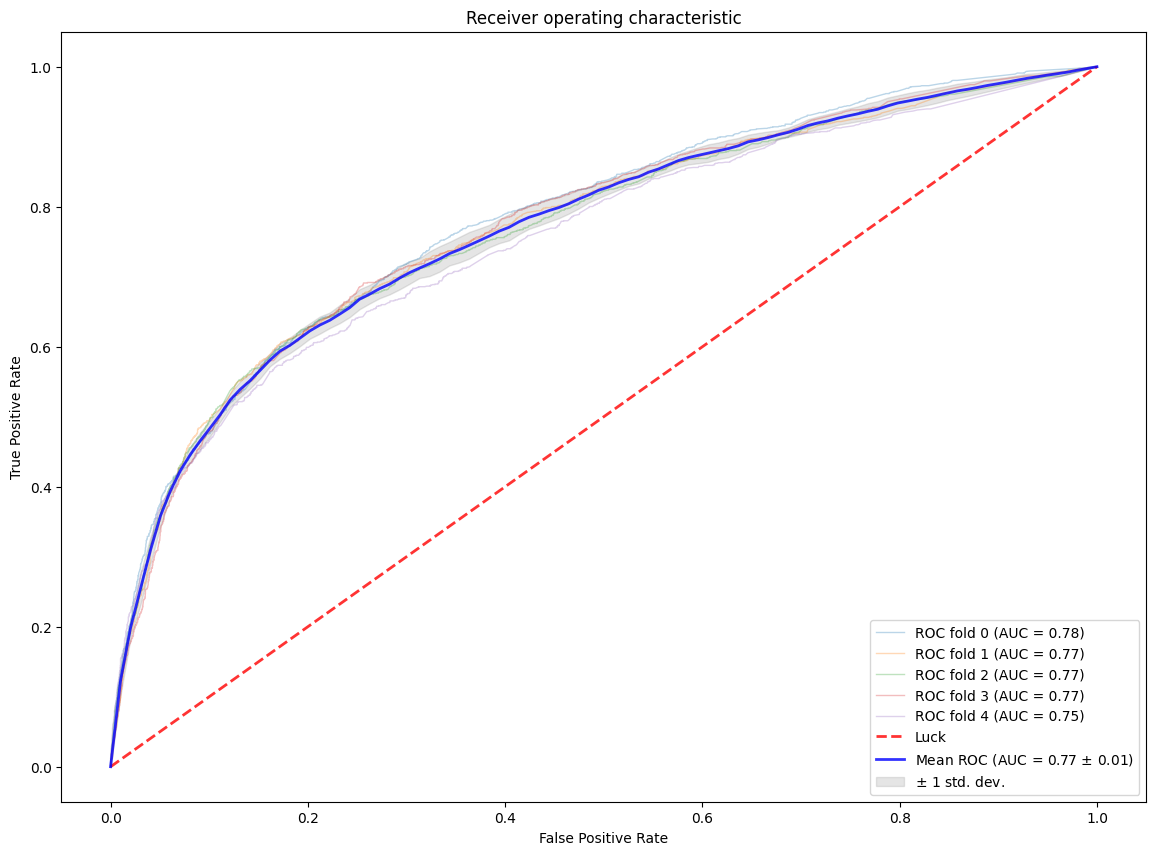

Accaracy list :  [0.8196666666666667, 0.8145, 0.813, 0.8101666666666667, 0.8176666666666667]
equal opportunity for tpr :  [0.028011178624918365, 0.010844663810765487, 0.045343154126798346, 0.033820399133692114, 0.0025901942645698006]
equal opportunity for fpr :  [0.003094492482848765, 0.01318860904739276, 0.011347021339599202, 0.011929758316816773, 0.009701962152741703]
odds difference list :  [0.015552835553883565, 0.012016636429079124, 0.028345087733198774, 0.022875078725254443, 0.006146078208655752]
The mean accuracy is  0.815 ± 0.003
The mean equal opportunity for tpr: (close to 0) 0.024 ± 0.015
The mean equal opportunity for fpr: (close to 0) 0.010 ± 0.004
The mean odds difference: (close to 0) 0.017 ± 0.008
The mean parity difference: (close to 0) 0.111 ± 0.050
The mean disperate impact: (close to 1) 0.399 ± 0.062


In [156]:
orig_acc ,orig_op_diff, orig_op_diff_fpr, orig_od_diff, orig_par_diff , orig_dis_impact  = fairness_metrics_roc_auc(orig_data, y_orig)

In [157]:
# X_train, y_train = dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
# X_test , y_test = dataset_orig_test.loc[:, dataset_orig_test.columns != 'Probability'], dataset_orig_test['Probability']

# clf = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100) # LSR

# print("recall :", measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'recall'))
# print("far :",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'far'))
# print("precision :", measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'precision'))
# print("accuracy :",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'accuracy'))
# print("F1 Score :",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'F1'))
# print("aod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'aod'))
# print("eod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'eod'))

# print("SPD:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'SPD'))
# print("DI:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'DI'))

# Find Class & Protected attribute Distribution

In [158]:
#Based on class
orig_data_one , orig_data_zero = [x for _, x in orig_dataset.groupby(orig_dataset[TARGET_COL] == 0)]

#Based on priv 1
one_one_df, one_zero_df = [x for _, x in orig_data_one.groupby(orig_data_one[PRIV_FEATURE] == 1)]
zero_one_df, zero_zero_df = [x for _, x in orig_data_zero.groupby(orig_data_zero[PRIV_FEATURE] == 1)]

one_one = one_one_df.shape[0]
one_zero = one_zero_df.shape[0]
zero_one = zero_one_df.shape[0]
zero_zero = zero_zero_df.shape[0]

print(zero_zero,zero_one,one_zero,one_one)

14349 9015 3763 2873


# Sort these four

In [159]:
maximum = max(zero_zero,zero_one,one_zero,one_one)
if maximum == zero_zero:
    print("zero_zero is maximum")
if maximum == zero_one:
    print("zero_one is maximum")
if maximum == one_zero:
    print("one_zero is maximum")
if maximum == one_one:
    print("one_one is maximum")

zero_zero is maximum


In [160]:
zero_zero_to_be_incresed = maximum - zero_zero ## where both are 0
one_zero_to_be_incresed = maximum - one_zero ## where class is 1 attribute is 0
zero_one_to_be_incresed = maximum - zero_one ## where class is 1 attribute is 1
one_one_to_be_incresed = maximum - one_one ## where class is 1 attribute is 1


print(zero_zero_to_be_incresed,one_zero_to_be_incresed,zero_one_to_be_incresed, one_one_to_be_incresed)

0 10586 5334 11476


In [161]:
zero_zero_df = generate_samples(zero_zero_to_be_incresed,zero_zero_df,'Default_Credit')
one_zero_df = generate_samples(one_zero_to_be_incresed,one_zero_df,'Default_Credit')
zero_one_df = generate_samples(zero_one_to_be_incresed,zero_one_df,'Default_Credit')
one_one_df = generate_samples(one_one_to_be_incresed,one_one_df,'Default_Credit')

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.p

In [162]:
zero_zero_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14349 entries, 0 to 14348
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          14349 non-null  float64
 1   LIMIT_BAL                   14349 non-null  float64
 2   SEX                         14349 non-null  float64
 3   EDUCATION                   14349 non-null  float64
 4   MARRIAGE                    14349 non-null  float64
 5   AGE                         14349 non-null  float64
 6   PAY_0                       14349 non-null  float64
 7   PAY_2                       14349 non-null  float64
 8   PAY_3                       14349 non-null  float64
 9   PAY_4                       14349 non-null  float64
 10  PAY_5                       14349 non-null  float64
 11  PAY_6                       14349 non-null  float64
 12  BILL_AMT1                   14349 non-null  float64
 13  BILL_AMT2                   143

# Append the dataframes

In [163]:
zero_zero_df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,0.000067,0.080808,1.0,0.333333,0.666667,0.224138,0.2,0.2,0.2,0.2,...,0.173637,0.095470,0.272928,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458,0.0
1,0.000100,0.040404,1.0,0.333333,0.333333,0.275862,0.2,0.2,0.2,0.2,...,0.186809,0.109363,0.283685,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892,0.0
2,0.000233,0.090909,1.0,0.333333,0.666667,0.034483,0.2,0.1,0.1,0.2,...,0.160346,0.080490,0.261414,0.000435,0.000357,0.000000,0.000936,0.003955,0.002917,0.0
3,0.000267,0.131313,1.0,0.500000,0.333333,0.120690,0.2,0.2,0.4,0.2,...,0.171640,0.092342,0.263837,0.003811,0.000000,0.000482,0.001610,0.002345,0.001892,0.0
4,0.000333,0.191919,1.0,0.500000,0.666667,0.224138,0.2,0.2,0.4,0.2,...,0.162505,0.082461,0.263846,0.002640,0.000007,0.000056,0.000483,0.008764,0.000125,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14344,0.972632,0.080808,1.0,0.500000,0.666667,0.672414,0.1,0.1,0.1,0.2,...,0.186398,0.107661,0.282342,0.072349,0.003160,0.029463,0.000878,0.001304,0.002410,0.0
14345,0.972732,0.161616,1.0,0.500000,0.333333,0.620690,0.2,0.2,0.2,0.2,...,0.314968,0.203986,0.353603,0.008357,0.004750,0.008705,0.007407,0.011723,0.009647,0.0
14346,0.972766,0.272727,1.0,0.166667,0.333333,0.603448,0.0,0.0,0.0,0.0,...,0.171905,0.084083,0.264003,0.005507,0.005912,0.013941,0.005586,0.009228,0.007273,0.0
14347,0.972866,0.040404,1.0,0.500000,0.666667,0.586207,0.4,0.2,0.2,0.2,...,0.176233,0.097623,0.274506,0.001423,0.000752,0.001763,0.000986,0.001777,0.001324,0.0


In [164]:
Upsampled_Dataset = pd.concat([zero_zero_df, zero_one_df, one_zero_df, one_one_df], ignore_index=True)
Upsampled_Dataset = Upsampled_Dataset.reset_index()



In [165]:
Upsampled_Dataset

,index,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,0,0.000067,0.080808,1.0,0.333333,0.666667,0.224138,0.20,0.20,0.2,...,0.173637,0.095470,0.272928,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458,0.0
1,1,0.000100,0.040404,1.0,0.333333,0.333333,0.275862,0.20,0.20,0.2,...,0.186809,0.109363,0.283685,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892,0.0
2,2,0.000233,0.090909,1.0,0.333333,0.666667,0.034483,0.20,0.10,0.1,...,0.160346,0.080490,0.261414,0.000435,0.000357,0.000000,0.000936,0.003955,0.002917,0.0
3,3,0.000267,0.131313,1.0,0.500000,0.333333,0.120690,0.20,0.20,0.4,...,0.171640,0.092342,0.263837,0.003811,0.000000,0.000482,0.001610,0.002345,0.001892,0.0
4,4,0.000333,0.191919,1.0,0.500000,0.666667,0.224138,0.20,0.20,0.4,...,0.162505,0.082461,0.263846,0.002640,0.000007,0.000056,0.000483,0.008764,0.000125,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57391,57391,0.338958,0.246465,0.0,0.033333,0.666667,0.037931,0.60,0.60,0.5,...,0.368631,0.305830,0.436970,0.000916,0.002162,0.008660,0.015137,0.013465,0.017902,1.0
57392,57392,0.557519,0.078788,0.0,0.033333,0.333333,0.272414,0.30,0.40,0.5,...,0.162803,0.083673,0.272027,0.002497,0.000014,0.000000,0.002585,0.004607,0.004231,1.0
57393,57393,0.099103,0.183838,0.0,0.333333,0.333333,0.403448,0.28,0.20,0.2,...,0.280357,0.208190,0.367108,0.007226,0.003103,0.007916,0.007649,0.031473,0.007188,1.0
57394,57394,0.067989,0.028283,0.0,0.166667,0.666667,0.162069,0.32,0.12,0.2,...,0.175148,0.088501,0.249754,0.000927,0.010362,0.005653,0.001694,0.014536,0.007498,1.0


In [166]:
Upsampled_Dataset
Upsampled_Dataset[TARGET_COL] = Upsampled_Dataset[TARGET_COL].astype(int)

In [167]:
y_upsampled = Upsampled_Dataset[TARGET_COL]
Upsampled_df_features = Upsampled_Dataset.loc[:, feature_columns]


In [168]:
Upsampled_df_features

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0.000067,0.080808,1.0,0.333333,0.666667,0.224138,0.20,0.20,0.2,0.2,...,0.093789,0.173637,0.095470,0.272928,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458
1,0.000100,0.040404,1.0,0.333333,0.333333,0.275862,0.20,0.20,0.2,0.2,...,0.113407,0.186809,0.109363,0.283685,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892
2,0.000233,0.090909,1.0,0.333333,0.666667,0.034483,0.20,0.10,0.1,0.2,...,0.086675,0.160346,0.080490,0.261414,0.000435,0.000357,0.000000,0.000936,0.003955,0.002917
3,0.000267,0.131313,1.0,0.500000,0.333333,0.120690,0.20,0.20,0.4,0.2,...,0.092992,0.171640,0.092342,0.263837,0.003811,0.000000,0.000482,0.001610,0.002345,0.001892
4,0.000333,0.191919,1.0,0.500000,0.666667,0.224138,0.20,0.20,0.4,0.2,...,0.089384,0.162505,0.082461,0.263846,0.002640,0.000007,0.000056,0.000483,0.008764,0.000125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57391,0.338958,0.246465,0.0,0.033333,0.666667,0.037931,0.60,0.60,0.5,0.4,...,0.206389,0.368631,0.305830,0.436970,0.000916,0.002162,0.008660,0.015137,0.013465,0.017902
57392,0.557519,0.078788,0.0,0.033333,0.333333,0.272414,0.30,0.40,0.5,0.4,...,0.092459,0.162803,0.083673,0.272027,0.002497,0.000014,0.000000,0.002585,0.004607,0.004231
57393,0.099103,0.183838,0.0,0.333333,0.333333,0.403448,0.28,0.20,0.2,0.2,...,0.154510,0.280357,0.208190,0.367108,0.007226,0.003103,0.007916,0.007649,0.031473,0.007188
57394,0.067989,0.028283,0.0,0.166667,0.666667,0.162069,0.32,0.12,0.2,0.2,...,0.103346,0.175148,0.088501,0.249754,0.000927,0.010362,0.005653,0.001694,0.014536,0.007498


In [169]:
y_upsampled

0        0
1        0
2        0
3        0
4        0
        ..
57391    1
57392    1
57393    1
57394    1
57395    1
Name: default payment next month, Length: 57396, dtype: int64

In [170]:
Upsampled_df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57396 entries, 0 to 57395
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         57396 non-null  float64
 1   LIMIT_BAL  57396 non-null  float64
 2   SEX        57396 non-null  float64
 3   EDUCATION  57396 non-null  float64
 4   MARRIAGE   57396 non-null  float64
 5   AGE        57396 non-null  float64
 6   PAY_0      57396 non-null  float64
 7   PAY_2      57396 non-null  float64
 8   PAY_3      57396 non-null  float64
 9   PAY_4      57396 non-null  float64
 10  PAY_5      57396 non-null  float64
 11  PAY_6      57396 non-null  float64
 12  BILL_AMT1  57396 non-null  float64
 13  BILL_AMT2  57396 non-null  float64
 14  BILL_AMT3  57396 non-null  float64
 15  BILL_AMT4  57396 non-null  float64
 16  BILL_AMT5  57396 non-null  float64
 17  BILL_AMT6  57396 non-null  float64
 18  PAY_AMT1   57396 non-null  float64
 19  PAY_AMT2   57396 non-null  float64
 20  PAY_AM

# Check score after oversampling

performance for whole ds:subexperiment - baseline Ensemble model:0
conf matrix:
  [[4688 1052]
 [1847 3893]] 
accuracy:  0.7474738675958188 precision:  0.7872598584428716 recall:  0.6782229965156794 fpr:  0.18327526132404182 tpr:  0.6782229965156794 fn+fp 2899
performance for 0 sub-group:
conf matrix:
  [[2429  419]
 [ 926 1917]] 
accuracy:  0.763661922333509 precision:  0.8206335616438356 recall:  0.6742877242349631 fpr:  0.14712078651685392 tpr:  0.6742877242349631 fn+fp 1345
performance for 1 sub-group:
conf matrix:
  [[2259  633]
 [ 921 1976]] 
accuracy:  0.7315598548972189 precision:  0.7573783058643159 recall:  0.6820849154297549 fpr:  0.21887966804979253 tpr:  0.6820849154297549 fn+fp 1554
bias metrics:
equal opportunity for tpr: (close to 0) 0.00779719119479183
equal opportunity for fpr: (close to 0) 0.0717588815329386
avarage absolute odds difference: (close to 0) 0.03977803636386522
statistical parity difference: (close to 0)  0.05520728008088982
disparate_impact: (close to 1

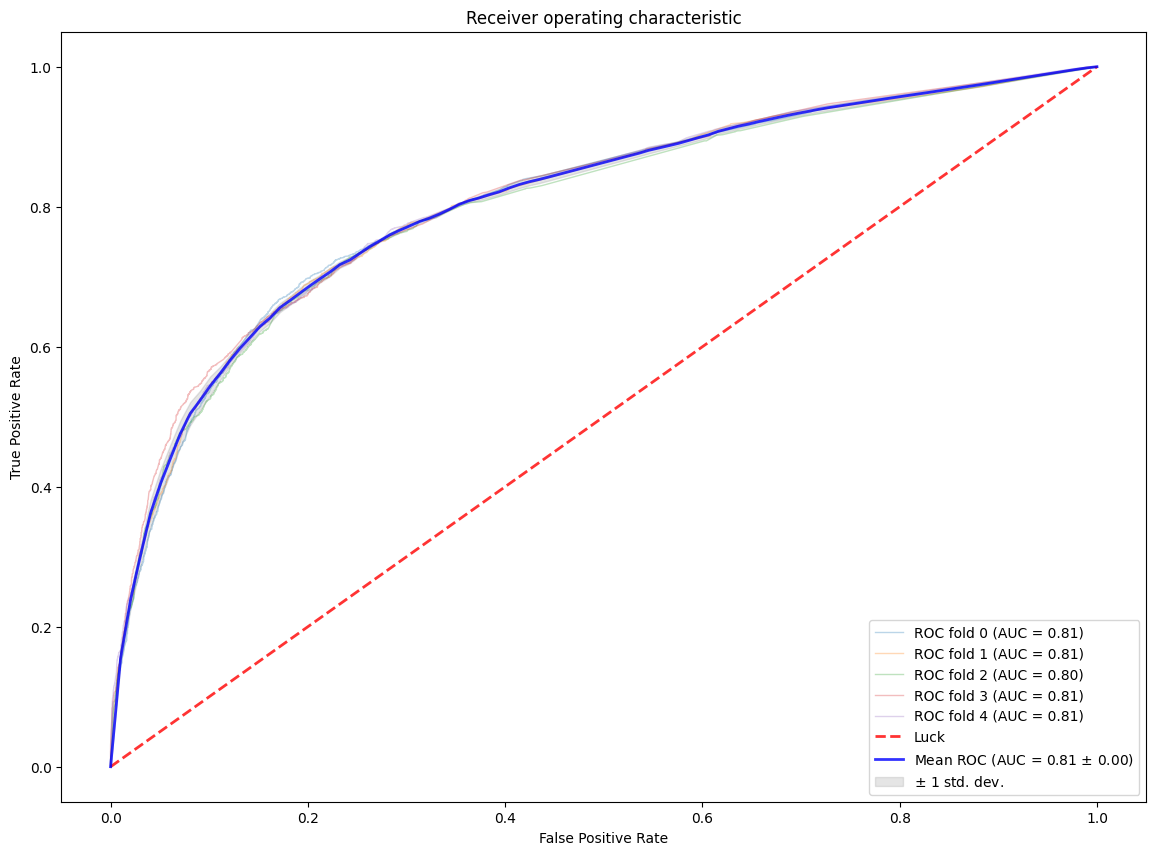

Accaracy list :  [0.7474738675958188, 0.7423120480878125, 0.7409181984493423, 0.739524348810872, 0.7394372332084677]
equal opportunity for tpr :  [0.00779719119479183, 0.009022149493597142, 0.010004857906242504, 0.017179310709936946, 0.0025536465545749065]
equal opportunity for fpr :  [0.0717588815329386, 0.07842363575107672, 0.07119365386791487, 0.08013907956522881, 0.07574300523068297]
odds difference list :  [0.03977803636386522, 0.04372289262233693, 0.04059925588707869, 0.04865919513758288, 0.03914832589262894]
The mean accuracy is  0.742 ± 0.003
The mean equal opportunity for tpr: (close to 0) 0.009 ± 0.005
The mean equal opportunity for fpr: (close to 0) 0.075 ± 0.004
The mean odds difference: (close to 0) 0.042 ± 0.004
The mean parity difference: (close to 0) 0.045 ± 0.014
The mean disperate impact: (close to 1) 0.477 ± 0.007


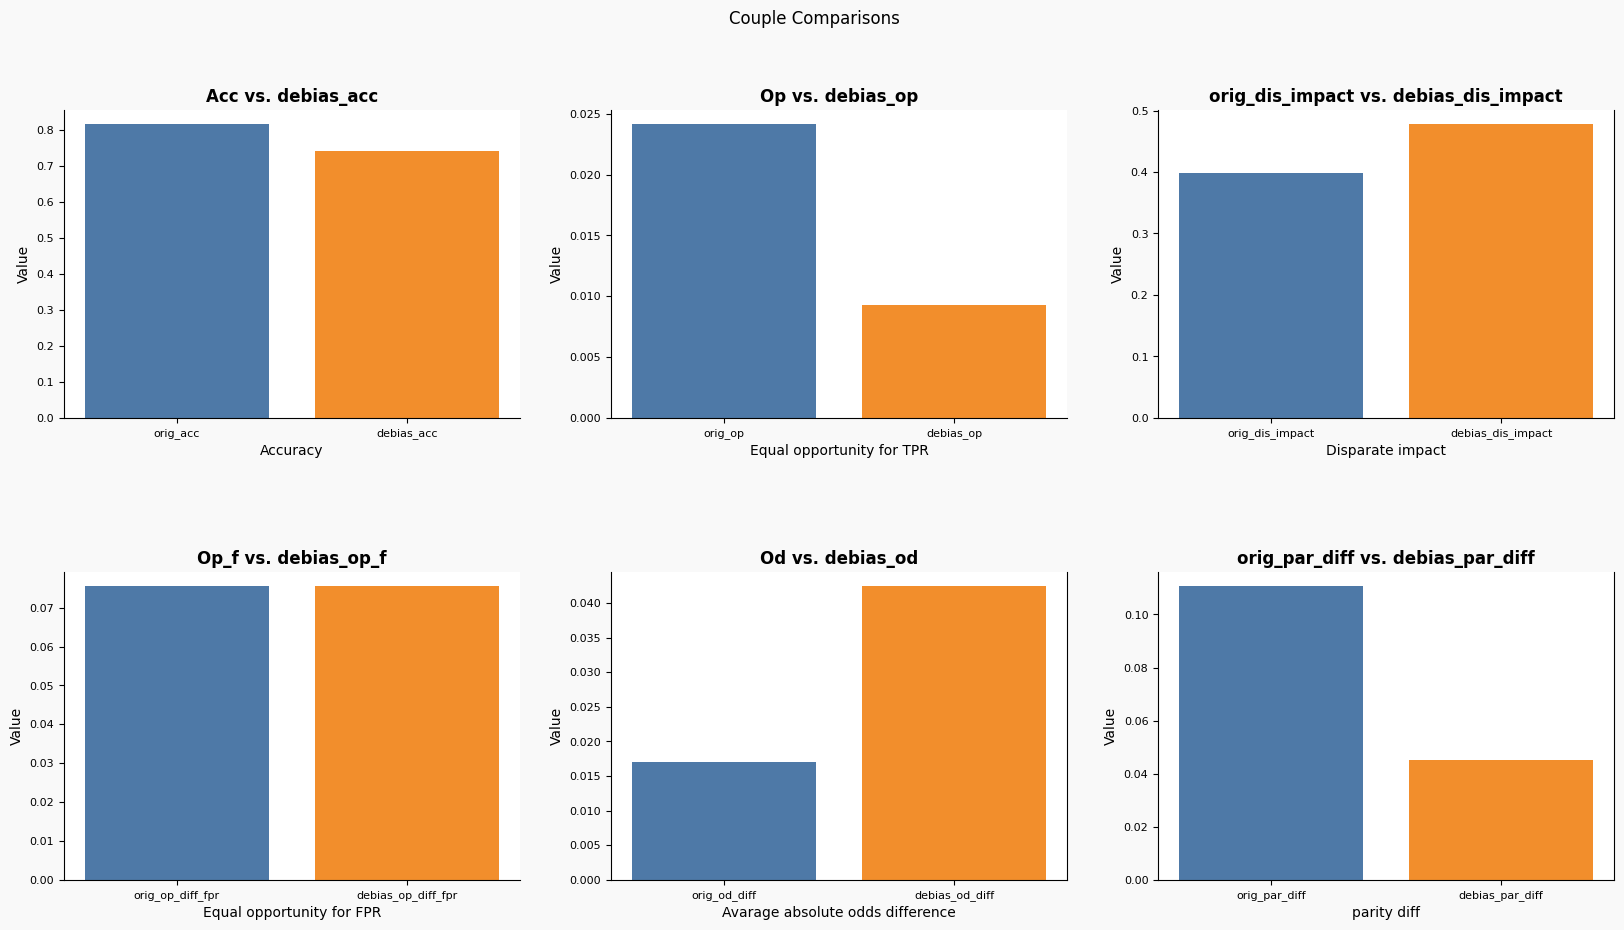

In [171]:
upsampled_acc, upsampled_op_diff, upsampled_op_diff_fpr, upsampled_od_diff, upsampled_par_diff, upsampled_dis_impact = fairness_metrics_roc_auc(Upsampled_df_features, y_upsampled)

# # Initialize wandb
# wandb.init(project="couple-comparisons")

# Create a bar plot for each couple comparison
fig, ax = plt.subplots(2, 3, figsize=(20, 10), dpi=100)
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Couple Comparisons')

# Set background color
fig.patch.set_facecolor('#f9f9f9')

# Acc vs. Pois_acc plot
ax[0, 0].bar(['orig_acc', 'debias_acc'], [mean(orig_acc), mean(upsampled_acc)], color=['#4e79a7', '#f28e2c'])
ax[0, 0].set_title('Acc vs. debias_acc', fontsize=12, fontweight='bold')
ax[0, 0].set_xlabel('Accuracy', fontsize=10)
ax[0, 0].set_ylabel('Value', fontsize=10)
ax[0, 0].tick_params(axis='both', which='major', labelsize=8)
ax[0, 0].spines['top'].set_visible(False)
ax[0, 0].spines['right'].set_visible(False)

# Op vs. Pois_op plot
ax[0, 1].bar(['orig_op','debias_op'], [mean(orig_op_diff), mean(upsampled_op_diff)], color=['#4e79a7', '#f28e2c'])
ax[0, 1].set_title('Op vs. debias_op', fontsize=12, fontweight='bold')
ax[0, 1].set_xlabel('Equal opportunity for TPR', fontsize=10)
ax[0, 1].set_ylabel('Value', fontsize=10)
ax[0, 1].tick_params(axis='both', which='major', labelsize=8)
ax[0, 1].spines['top'].set_visible(False)
ax[0, 1].spines['right'].set_visible(False)

# Op_f vs. Pois_op_f plotdebias
ax[1, 0].bar(['orig_op_diff_fpr', 'debias_op_diff_fpr'], [mean(upsampled_op_diff_fpr), mean(upsampled_op_diff_fpr)], color=['#4e79a7', '#f28e2c'])
ax[1, 0].set_title('Op_f vs. debias_op_f', fontsize=12, fontweight='bold')
ax[1, 0].set_xlabel('Equal opportunity for FPR', fontsize=10)
ax[1, 0].set_ylabel('Value', fontsize=10)
ax[1, 0].tick_params(axis='both', which='major', labelsize=8)
ax[1, 0].spines['top'].set_visible(False)
ax[1, 0].spines['right'].set_visible(False)

# Od vs. Pois_od plot
ax[1, 1].bar(['orig_od_diff', 'debias_od_diff'], [mean(orig_od_diff), mean(upsampled_od_diff)], color=['#4e79a7', '#f28e2c'])
ax[1, 1].set_title('Od vs. debias_od', fontsize=12, fontweight='bold')
ax[1, 1].set_xlabel('Avarage absolute odds difference', fontsize=10)
ax[1, 1].set_ylabel('Value', fontsize=10)
ax[1, 1].tick_params(axis='both', which='major', labelsize=8)
ax[1, 1].spines['top'].set_visible(False)
ax[1, 1].spines

# Od vs. Pois_od plot
ax[1, 2].bar(['orig_par_diff', 'debias_par_diff'], [mean(orig_par_diff), mean(upsampled_par_diff)], color=['#4e79a7', '#f28e2c'])
ax[1, 2].set_title('orig_par_diff vs. debias_par_diff', fontsize=12, fontweight='bold')
ax[1, 2].set_xlabel('parity diff', fontsize=10)
ax[1, 2].set_ylabel('Value', fontsize=10)
ax[1, 2].tick_params(axis='both', which='major', labelsize=8)
ax[1, 2].spines['top'].set_visible(False)
ax[1, 2].spines

# Od vs. Pois_od plot
ax[0, 2].bar(['orig_dis_impact', 'debias_dis_impact'], [mean(orig_dis_impact), mean(upsampled_dis_impact)], color=['#4e79a7', '#f28e2c'])
ax[0, 2].set_title('orig_dis_impact vs. debias_dis_impact', fontsize=12, fontweight='bold')
ax[0, 2].set_xlabel('Disparate impact', fontsize=10)
ax[0, 2].set_ylabel('Value', fontsize=10)
ax[0, 2].tick_params(axis='both', which='major', labelsize=8)
ax[0, 2].spines['top'].set_visible(False)
ax[0, 2].spines


In [172]:
# X_train, y_train = df.loc[:, df.columns != 'Probability'], df['Probability']
# X_test , y_test = dataset_orig_test.loc[:, dataset_orig_test.columns != 'Probability'], dataset_orig_test['Probability']

# clf = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100) # LSR

# print("recall :", measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'recall'))
# print("far :",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'far'))
# print("precision :", measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'precision'))
# print("accuracy :",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'accuracy'))
# print("F1 Score :",measure_final_score(dataset_orig_tesst, clf, X_train, y_train, X_test, y_test, protected_attribute, 'F1'))
# print("aod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'aod'))
# print("eod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'eod'))

# print("SPD:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'SPD'))
# print("DI:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'DI'))

# Verification

In [173]:
# first one is class value and second one is protected attribute value
zero_zero = len(Upsampled_Dataset[(Upsampled_Dataset[TARGET_COL] == 0) & (Upsampled_Dataset[PRIV_FEATURE] == 0)])
zero_one = len(Upsampled_Dataset[(Upsampled_Dataset[TARGET_COL] == 0) & (Upsampled_Dataset[PRIV_FEATURE] == 1)])
one_zero = len(Upsampled_Dataset[(Upsampled_Dataset[TARGET_COL] == 1) & (Upsampled_Dataset[PRIV_FEATURE] == 0)])
one_one = len(Upsampled_Dataset[(Upsampled_Dataset[TARGET_COL] == 1) & (Upsampled_Dataset[PRIV_FEATURE] == 1)])

print(zero_zero,zero_one,one_zero,one_one)

14349 14349 14349 14349


In [174]:
# Record the end time
end_time = time.time()

In [175]:
# Calculate the elapsed time in minutes
elapsed_time_minutes = (end_time - start_time) / 60
print(f"Elapsed time: {elapsed_time_minutes:.4f} minutes")

Elapsed time: 2.7215 minutes
